# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [0]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os
import prettytable

In [99]:
# Code to read csv file into colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

#2. Get the file #Training Variants
downloaded = drive.CreateFile({'id':'1PPCURbwWREuTo7ZgIt9MZv26tpsAp9Bs'}) # replace the id with id of file you want to access
downloaded.GetContentFile('Reviews.csv')

downloaded1 = drive.CreateFile({'id':'1PPC'}) # replace the id with id of file you want to access
downloaded.GetContentFile('Reviews.csv')

downloaded = drive.CreateFile({'id':'1PPCURbwWREuTo7ZgIt9MZv26tpsAp9Bs'}) # replace the id with id of file you want to access
downloaded.GetContentFile('Reviews.csv')

downloaded = drive.CreateFile({'id':'1PPCURbwWREuTo7ZgIt9MZv26tpsAp9Bs'}) # replace the id with id of file you want to access
downloaded.GetContentFile('Reviews.csv')

#3. Read file as panda dataframe
import pandas as pd
data = pd.read_csv('Reviews.csv')

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.locked_file'

During handling of the above exception, another exceptio

In [0]:
#USER DEFINED FUNCTIONS

#changing reviews with score less than 3 to be positive and vice-versa
def data_filter(filtered_data):
    actualScore = filtered_data['Score']
    positiveNegative = actualScore.map(partition) 
    filtered_data['Score'] = positiveNegative
    return filtered_data["Score"]


# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

In [101]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

#Reading equal amount of positive and negative data.
filtered_data_1 = data[data["Score"]>3][0:50000]
filtered_data_2 = data[data["Score"]<=2][0:50000]

filtered_data_1["Score"] = data_filter(filtered_data_1)
filtered_data_2["Score"] = data_filter(filtered_data_2)

'''
# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa

def data_filter(filtered_data):
    actualScore = filtered_data['Score']
    positiveNegative = actualScore.map(partition) 
    filtered_data['Score'] = positiveNegative
    return filtered_data["Score"]


#print("Number of data points in our data", filtered_data.shape)
#filtered_data.head(3)
'''

'\n# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).\ndef partition(x):\n    if x < 3:\n        return 0\n    return 1\n\n#changing reviews with score less than 3 to be positive and vice-versa\n\ndef data_filter(filtered_data):\n    actualScore = filtered_data[\'Score\']\n    positiveNegative = actualScore.map(partition) \n    filtered_data[\'Score\'] = positiveNegative\n    return filtered_data["Score"]\n\n\n#print("Number of data points in our data", filtered_data.shape)\n#filtered_data.head(3)\n'

In [0]:
#Stacking both positive and negative data
filtered_data = filtered_data_1.append(filtered_data_2, ignore_index = True)

In [103]:
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (100000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
2,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,1,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [0]:
#Shuffling the data points to mix the data
from sklearn.utils import shuffle
filtered_data = shuffle(filtered_data)

In [105]:
filtered_data.reset_index(drop = True)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,285118,B001E5E3JY,A20G1010XJ8XTM,Sarah,5,6,0,1290643200,It doesn't taste very good.,SweetLeaf SteviaClear liquid does not taste go...
1,99895,B000LKYYMO,A1H7PDEBFZ0WWI,Melissa Engel,1,2,0,1226275200,Soy Chips...expired!,I ordered a box of 24 bags of soy chips. I rec...
2,32048,B0062A87HA,A281G4F0B1PZJI,oppspring,1,1,1,1297296000,"Good product, nicer than the big name brand","Good product, nicer than the big name brand we..."
3,63276,B005J8U99K,AP6GGUWXS9TZK,The Golphur,0,0,0,1332806400,Flavorless,Prior purchases were darker and had a lot more...
4,53830,B000H25WMW,A3FC89RPC2PC3J,tickles_leanne,2,2,1,1288656000,delicious!,Highly recommend this soup. I use less water t...
5,60342,B001EO62IU,A6U68E5GISFD3,Joeitalia,1,1,1,1258156800,next best to h2o,Coconut water is great. After a run or a littl...
6,245702,B004OAZ36I,A2QSSYUJBJYH16,Leah P. Axelrod,0,0,0,1328918400,Assortment Doesn't Match the description,Here is what I received:<br /><br />7 Hazelnut...
7,33809,B001E5E0I8,A3KTLQL58GF2RV,"Jason Conlon ""&#34;mr. gringo&#34;""",2,2,1,1275782400,excellent,These are addictive. The only reason it didn't...
8,46146,B000NSJ5U0,A1TIVD0Y3KJSCN,"lawyerwhocooks ""lawyerwhocooks""",11,11,1,1264809600,"Excellent flavor, beautiful Beluga lentils",I'm sorry to see these lentils have disappeare...
9,188721,B000HJPBGC,A2OX7WYR9SKYSO,db,4,8,0,1271894400,Jamaican me want something else!,"Well, taste is very subjective, but I think I'..."


In [106]:
'''display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)'''

'display = pd.read_sql_query("""\nSELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)\nFROM Reviews\nGROUP BY UserId\nHAVING COUNT(*)>1\n""", con)'

In [107]:
'''print(display.shape)
display.head()'''

'print(display.shape)\ndisplay.head()'

In [0]:
#display[display['UserId']=='AZY10LLTJ71NX']

In [0]:
#display['COUNT(*)'].sum()

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [110]:
'''display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()'''

'display= pd.read_sql_query("""\nSELECT *\nFROM Reviews\nWHERE Score != 3 AND UserId="AR5J8UI46CURR"\nORDER BY ProductID\n""", con)\ndisplay.head()'

As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [0]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [112]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(83317, 10)

In [113]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

83.317

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [114]:
'''display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()'''

'display= pd.read_sql_query("""\nSELECT *\nFROM Reviews\nWHERE Score != 3 AND Id=44737 OR Id=64422\nORDER BY ProductID\n""", con)\n\ndisplay.head()'

In [0]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [116]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(83315, 10)


1    45420
0    37895
Name: Score, dtype: int64

In [117]:
final.shape

(83315, 10)

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [118]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4300]
print(sent_4900)
print("="*50)

This is one of the best children's books ever written but it is a mini version of the book and was not portrayed as one.  It is over priced for the product.  I sent an email regarding my bewilderment  to Amazon and got no response.
Please do not take this review as a dare. Please heed its caution with the utmost of seriousness.<br /><br />If you come across a bag like this, do not open it. The consequences will be great, but I'll get to those later. As for proper disposal, do not let ANYONE see these, as they might be tempted into opening them, seeing the deceptive word "cookie" included in the title. You have two options, both of which require items that are difficult to obtain, but which are the only acceptable ways for destruction to ensure these ruinous abominations don't return as even worse creatures. The first is to find some thermite or a similar accelerant that can burn this at over 4000 degrees F. The second option is to use a rocket that can escape Earth's orbit; you must ca

In [119]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

This is one of the best children's books ever written but it is a mini version of the book and was not portrayed as one.  It is over priced for the product.  I sent an email regarding my bewilderment  to Amazon and got no response.


In [120]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

This is one of the best children's books ever written but it is a mini version of the book and was not portrayed as one.  It is over priced for the product.  I sent an email regarding my bewilderment  to Amazon and got no response.
Please do not take this review as a dare. Please heed its caution with the utmost of seriousness.If you come across a bag like this, do not open it. The consequences will be great, but I'll get to those later. As for proper disposal, do not let ANYONE see these, as they might be tempted into opening them, seeing the deceptive word "cookie" included in the title. You have two options, both of which require items that are difficult to obtain, but which are the only acceptable ways for destruction to ensure these ruinous abominations don't return as even worse creatures. The first is to find some thermite or a similar accelerant that can burn this at over 4000 degrees F. The second option is to use a rocket that can escape Earth's orbit; you must carefully calc

In [0]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [122]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

I was disappointed by these eucalyptus leaves - they have a stale, oregano-like smell. Ask your local florist to get you some fresh leaves!


In [123]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

This is one of the best children's books ever written but it is a mini version of the book and was not portrayed as one.  It is over priced for the product.  I sent an email regarding my bewilderment  to Amazon and got no response.


In [124]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

I was disappointed by these eucalyptus leaves they have a stale oregano like smell Ask your local florist to get you some fresh leaves 


In [0]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [126]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████| 83315/83315 [00:36<00:00, 2282.26it/s]


In [127]:
preprocessed_reviews[1500]

'disappointed eucalyptus leaves stale oregano like smell ask local florist get fresh leaves'

In [0]:
#Length of reviews

length = [len(i) for i in preprocessed_reviews]
df = pd.DataFrame(preprocessed_reviews, columns = ["Reviews"])
df["Length"] = length

In [129]:
df.shape

(83315, 2)

In [0]:
#Train-Test Split

X_train,X_test,y_train, y_test = train_test_split(df, list(final["Score"]), random_state = 42, test_size = 0.3, stratify = list(final["Score"]))

In [0]:
# Seperating Reviews and length of reviews

length_train = X_train["Length"]
length_test = X_test["Length"]

X_train.drop("Length", axis = 1, inplace = True)
X_test.drop("Length", axis = 1, inplace = True)

length_train = pd.DataFrame(length_train)
length_test = pd.DataFrame(length_test)

<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

In [0]:
## Similartly you can do preprocessing for review summary also.

# [4] Featurization

## [4.1] BAG OF WORDS

In [133]:
#BoW
count_vect = CountVectorizer() #in scikit-learn
count_vect.fit(X_train["Reviews"])
print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)

final_counts = count_vect.transform(X_train["Reviews"])
final_counts_test = count_vect.transform(X_test["Reviews"])

final_counts = hstack([final_counts, length_train])
final_counts_test = hstack([final_counts_test, length_test])

print("the type of count vectorizer ",type(final_counts))
print("the shape of out text BOW vectorizer ",final_counts.get_shape())
print("the number of unique words ", final_counts.get_shape()[1])
print("="*50)
print("for test data")
print("the type of count vectorizer ",type(final_counts_test))
print("the shape of out text BOW vectorizer ",final_counts_test.get_shape())
print("the number of unique words ", final_counts_test.get_shape()[1])

some feature names  ['aa', 'aaa', 'aaaa', 'aaaaa', 'aaaaaaaaaaaa', 'aaaaaaahhhhhh', 'aaaaaaarrrrrggghhh', 'aaaaaahhhhhyaaaaaa', 'aaaaaawwwwwwwwww', 'aaaaah']
the type of count vectorizer  <class 'scipy.sparse.coo.coo_matrix'>
the shape of out text BOW vectorizer  (58320, 46332)
the number of unique words  46332
for test data
the type of count vectorizer  <class 'scipy.sparse.coo.coo_matrix'>
the shape of out text BOW vectorizer  (24995, 46332)
the number of unique words  46332


## [4.2] Bi-Grams and n-Grams.

In [134]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
# count_vect = CountVectorizer(ngram_range=(1,2))
# please do read the CountVectorizer documentation http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

# you can choose these numebrs min_df=10, max_features=5000, of your choice
count_vect = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)
final_bigram_counts = count_vect.fit_transform(X_train["Reviews"])
final_bigram_counts_test = count_vect.transform(X_test["Reviews"])

final_bigram_counts = hstack([final_bigram_counts, length_train])
final_bigram_counts_test = hstack([final_bigram_counts_test, length_test])

print("the type of count vectorizer ",type(final_bigram_counts))
print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])

print("="*50)
print("for test data")

print("the type of count vectorizer ",type(final_bigram_counts_test))
print("the shape of out text BOW vectorizer ",final_bigram_counts_test.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_counts_test.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.coo.coo_matrix'>
the shape of out text BOW vectorizer  (58320, 5001)
the number of unique words including both unigrams and bigrams  5001
for test data
the type of count vectorizer  <class 'scipy.sparse.coo.coo_matrix'>
the shape of out text BOW vectorizer  (24995, 5001)
the number of unique words including both unigrams and bigrams  5001


## [4.3] TF-IDF

In [135]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tf_idf_vect.fit(X_train["Reviews"])
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

final_tf_idf = tf_idf_vect.transform(X_train["Reviews"])
final_tf_idf_test = tf_idf_vect.transform(X_test["Reviews"])

final_tf_idf = hstack([final_tf_idf, length_train])
final_tf_idf_test = hstack([final_tf_idf_test, length_test])

print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

print("="*50)
print("for test data")

print("the type of count vectorizer ",type(final_tf_idf_test))
print("the shape of out text TFIDF vectorizer ",final_tf_idf_test.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf_test.get_shape()[1])

some sample features(unique words in the corpus) ['aback', 'abandoned', 'abdominal', 'abdominal pain', 'ability', 'able', 'able buy', 'able chew', 'able drink', 'able eat']
the type of count vectorizer  <class 'scipy.sparse.coo.coo_matrix'>
the shape of out text TFIDF vectorizer  (58320, 35059)
the number of unique words including both unigrams and bigrams  35059
for test data
the type of count vectorizer  <class 'scipy.sparse.coo.coo_matrix'>
the shape of out text TFIDF vectorizer  (24995, 35059)
the number of unique words including both unigrams and bigrams  35059


# Applying Multinomial Naive Bayes

In [0]:
# Common User defined function used.

#Plots AUC Score vs Neighbors 
def plot_best_hyperparameter(gridcv):            
    cv_result = pd.DataFrame(gridcv.cv_results_)      #gridcv.cv_results_ outputs dict object of cross validation score and train score. 
    '''cv = {
    "neighbors" : cv_result["param_n_neighbors"],
    "train score" : cv_result["mean_train_score"],
    "validation score" : cv_result["mean_test_score"]}'''

    #CV_score = pd.DataFrame(cv)
    
    #Plot for Train data
    plt.figure()
    plt.title("Best hyperparameter for train data")
    plt.plot(cv_result["param_alpha"], cv_result["mean_train_score"])
    plt.xticks(rotation=90)
    plt.xlabel("Alpha")
    plt.ylabel("AUC Score")
    plt.show()
    
    #Plot for Validation data
    plt.figure()
    plt.title("Best hyperparameter for validation data")
    plt.plot(cv_result["param_alpha"], cv_result["mean_test_score"])
    plt.xticks(rotation=90)
    plt.xlabel("Alpha")
    plt.ylabel("AUC Score")
    plt.show()


def plot_roc_curve(test_y, predict_proba_y):     #Plots ROC Curve
    
    fpr, tpr, threshold = roc_curve(test_y, predict_proba_y)
    auc_area = metrics.auc(fpr, tpr)
    
    plt.figure()
    plt.plot(fpr, tpr, color = 'darkorange', linewidth = 2,label = "AUC: %0.2f" %auc_area)
    plt.plot([0,1],[0,1], linewidth = 2, linestyle="--")
    plt.xlim([0,1])
    plt.ylim([0,1])
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.title("ROC Curve")
    plt.legend(loc = "lower right")
    plt.show()
    

    
def plot_confusion_mat(test_y, predict_proba_y):    #Plots Confusion Matrix

    cnf_mat = confusion_matrix(test_y, predict_proba_y)
    cnf_df = pd.DataFrame(cnf_mat, index = ["Actual: 0", "Actual: 1"], columns = ["Predicted: 0", "Predicted: 1"], dtype= float)

    plt.figure(figsize=(5,3))
    plt.title("Confusion Matrix")
    sns.heatmap(cnf_df, annot = True, fmt = "g")
    

def top_features(model,vector):                    #Returns Positive and Negative top 10 features
    vbg_positive = sorted(zip(model.feature_log_prob_[0], vector.get_feature_names()))[0:10]
    vbg_negative = sorted(zip(model.feature_log_prob_[1], vector.get_feature_names()))[0:10]
    return vbg_positive, vbg_negative



## [5.1] Applying Naive Bayes on BOW,<font color='red'> SET 1</font>

{'alpha': 0.01}


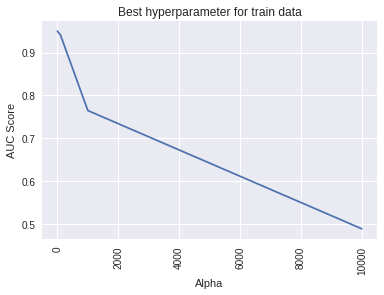

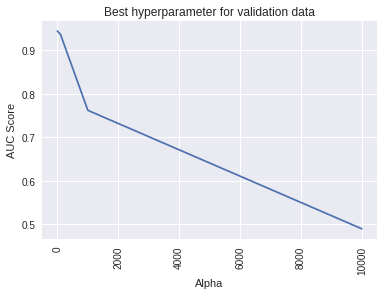

In [137]:
# Please write all the code with proper documentation

from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB

#Parameters
params = {"alpha":[10**(-4), 10**(-3), 10**(-2),10**(-1),10**(0),10**(1),10**(2),10**(3),10**(4)]
         }

knn_bow = MultinomialNB()

gridcv = GridSearchCV(knn_bow, params, scoring = 'roc_auc', cv = 5)
gridcv.fit(final_bigram_counts, y_train)
print(gridcv.best_params_)
bst_paramtr = gridcv.best_params_["alpha"]

#Plots the graph for all  parameters to find best hyperparameter.
plot_best_hyperparameter(gridcv)

AUC for Naive Bayes with BOW:  0.9431391266046628


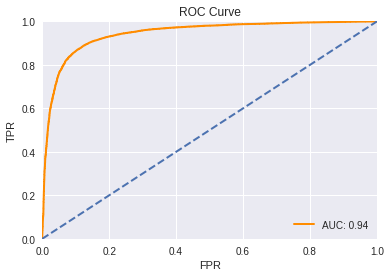

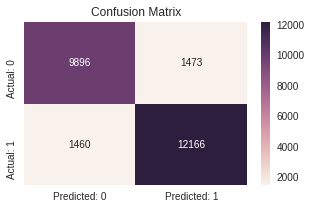

In [138]:
from sklearn.metrics import roc_auc_score

knn_bow_1 = MultinomialNB(alpha = bst_paramtr )
knn_bow_1.fit(final_bigram_counts, y_train)

y_predict_proba_bow = knn_bow_1.predict_proba(final_bigram_counts_test)[:,1]
y_predict_bow = knn_bow_1.predict(final_bigram_counts_test)

roc_auc = roc_auc_score(y_test, y_predict_proba_bow)
print("AUC for Naive Bayes with BOW: ", roc_auc)

#Plots ROC curve
plot_roc_curve(y_test, y_predict_proba_bow)

#Plots Confusion matrix
plot_confusion_mat(y_test, y_predict_bow)

In [139]:
#Printing Positive and Negative features

pos, neg = top_features(knn_bow_1, count_vect)

print("Top features for positive reviews: ", pos)
print(" ")
print("Top features for negative reviews: ", neg)

Top features for positive reviews:  [(-15.280461133298706, 'definitely order'), (-15.280461133298706, 'petite cuisine'), (-14.876655776608906, 'addicting'), (-14.876655776608906, 'also great'), (-14.876655776608906, 'far favorite'), (-14.876655776608906, 'no bitterness'), (-14.876655776608906, 'stuff great'), (-14.876655776608906, 'worth every'), (-14.589804614051213, 'absolute favorite'), (-14.589804614051213, 'absolutely loves')]
 
Top features for negative reviews:  [(-20.635993845272452, 'brezza'), (-20.635993845272452, 'threw rest'), (-16.020873328431193, 'extremely disappointed'), (-16.020873328431193, 'returnable'), (-16.020873328431193, 'total waste'), (-16.020873328431193, 'two stars'), (-15.332688937213378, 'one worst'), (-15.332688937213378, 'worst tasting'), (-14.928883580523578, 'awful not'), (-14.928883580523578, 'ended throwing')]


## [5.2] Applying Naive Bayes on TFIDF,<font color='red'> SET 2</font>

{'alpha': 0.1}


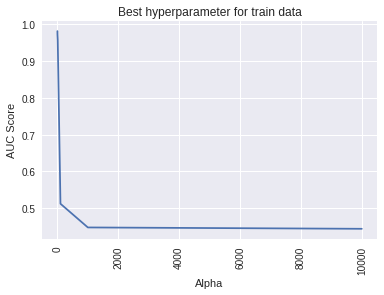

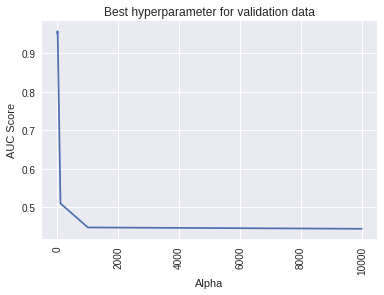

In [140]:
# Please write all the code with proper documentation

#Parameters
params = {"alpha":[10**(-4), 10**(-3), 10**(-2),10**(-1),10**(0),10**(1),10**(2),10**(3),10**(4)]
         }

knn_bow = MultinomialNB()

gridcv = GridSearchCV(knn_bow, params, scoring = 'roc_auc', cv = 5)
gridcv.fit(final_tf_idf, y_train)
print(gridcv.best_params_)
bst_paramtr = gridcv.best_params_["alpha"]

#Plots the graph for all  parameters to find best hyperparameter.
plot_best_hyperparameter(gridcv)

AUC for Naive Bayes with TFIDF vectorizer:  0.956523624327961


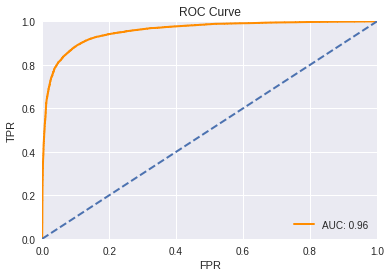

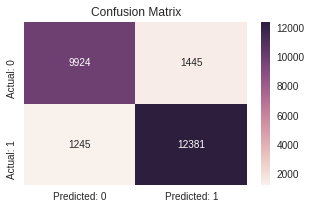

In [141]:
knn_bow_1 = MultinomialNB(alpha = bst_paramtr )
knn_bow_1.fit(final_tf_idf, y_train)

y_predict_proba_tfidf = knn_bow_1.predict_proba(final_tf_idf_test)[:,1]
y_predict_tfidf = knn_bow_1.predict(final_tf_idf_test)

roc_auc = roc_auc_score(y_test, y_predict_proba_tfidf)

print("AUC for Naive Bayes with TFIDF vectorizer: ", roc_auc)

#Plots ROC curve
plot_roc_curve(y_test, y_predict_proba_tfidf)

#Plots Confusion matrix
plot_confusion_mat(y_test, y_predict_tfidf)

In [142]:
#Printing Positive and Negative features

pos, neg = top_features(knn_bow_1, tf_idf_vect)

print("Top features for positive reviews: ", pos)
print(" ")
print("Top features for negative reviews: ", neg)

Top features for positive reviews:  [(-18.159406310362687, 'absolutely amazing'), (-18.159406310362687, 'add couple'), (-18.159406310362687, 'add ground'), (-18.159406310362687, 'add protein'), (-18.159406310362687, 'adds great'), (-18.159406310362687, 'adds nice'), (-18.159406310362687, 'adds right'), (-18.159406310362687, 'afternoon treat'), (-18.159406310362687, 'allergies tried'), (-18.159406310362687, 'alliance')]
 
Top features for negative reviews:  [(-18.211663673546095, 'able return'), (-18.211663673546095, 'abomination'), (-18.211663673546095, 'absolutely awful'), (-18.211663673546095, 'absolutely disgusting'), (-18.211663673546095, 'absolutely horrible'), (-18.211663673546095, 'absolutely terrible'), (-18.211663673546095, 'absolutely worst'), (-18.211663673546095, 'accept returns'), (-18.211663673546095, 'add insult'), (-18.211663673546095, 'advertising not')]


# [6] Conclusions

In [144]:
# Please compare all your models using Prettytable library

print("\nNote: In this jupyter notebook I have just used 100K datapoints.\n")

print("\nTable: Summary of all the Vectorization techniques used.")

table = prettytable.PrettyTable()
table.field_names=["Model", "Vectorization Technique","Best Alpha", "AUC Test Score"]

table.add_row(["Naive Bayes","BOW",0.01, 0.9431])
table.add_row(["Naive Bayes","TFIDF",0.1, 0.9565])


print(table)


print("\nLooking at the above table, we can conclude that for the given dataset, Naive Bayes model with TFIDF vectorization and seems to give the better AUC Score of 0.9565")


Note: In this jupyter notebook I have just used 100K datapoints.


Table: Summary of all the Vectorization techniques used.
+-------------+-------------------------+------------+----------------+
|    Model    | Vectorization Technique | Best Alpha | AUC Test Score |
+-------------+-------------------------+------------+----------------+
| Naive Bayes |           BOW           |    0.01    |     0.9431     |
| Naive Bayes |          TFIDF          |    0.1     |     0.9565     |
+-------------+-------------------------+------------+----------------+

Looking at the above table, we can conclude that for the given dataset, Naive Bayes model with TFIDF vectorization and seems to give the better AUC Score of 0.9565
